In [1]:
from fredapi import Fred
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
from functools import reduce
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Key: 02d60bd3174b5444867a02671ae80475
api_key = input("Please input your FRED API Key:\n").strip()
fred = Fred(api_key=api_key)

Please input your FRED API Key:
02d60bd3174b5444867a02671ae80475


In [3]:
def get_fred_series(name: str, date: str, label: str, to_frame: bool = True, pct_change: bool = False, periods: int = None, freq=None):
    """ Gets the FRED Series in Name, from Date, and inputs the data into a label 
        Assumes that data is in format of: "date", "value"
    """
    series = fred.get_series(name)
    if to_frame:
        series = series.to_frame()
    if pct_change:
        if not freq and not periods:
            series = series.pct_change()
        elif freq:
            series = series.pct_change(freq=freq)
        elif periods:
            series = series.pct_change(periods=periods)
    series = series.loc[date:]
    series[label] = series[0]
    return series.drop(columns = 0)

In [144]:
canada_recession = get_fred_series('CANRECDM', '1970-01-01', 'Recession')

In [142]:
canada_gdp = get_fred_series('MKTGDPCAA646NWDB', '1970-01-01', 'GDP')

In [145]:
canada_gdp_pctcg = get_fred_series('MKTGDPCAA646NWDB', '1970-01-01', 'GDP_%Change', pct_change=True)

In [146]:
unemp = get_fred_series('LRUNTTTTCAM156S', '1970-01-01', 'Unemp')
unemp = unemp.iloc[::3, :]

In [147]:
unemp_pct = get_fred_series('LRUNTTTTCAM156S', '1970-01-01', 'Unemp % Change', pct_change=True, periods=3).iloc[::3, :]

In [148]:
nascom_pct = get_fred_series('NASDAQCOM', '1970-01-01', 'NASDAQCOM % Chg', pct_change=True, freq='Q')
nascom_pct = nascom_pct.loc[nascom_pct['NASDAQCOM % Chg'].notnull() == True]
nascom_pct.index = nascom_pct.index + pd.Timedelta('1 day')

In [149]:
bond10y = get_fred_series('IRLTLT01CAM156N', '1970-01-01', '10Y-bonds')

In [150]:
canada_inflation = get_fred_series('FPCPITOTLZGCAN', '1970-01-01', 'Inflation')

In [151]:
canada_employees = get_fred_series('LFEAMNTTCAM647S', '1970-01-01', 'ManufactureEmps')

In [152]:
canada_employees_chg = get_fred_series('LFEAMNTTCAM647S', '1970-01-01', 'ManuEmps % Change', pct_change = True).dropna()

In [153]:
loans_pctchg = get_fred_series('TOTCI', '1970-01-01', 'Commercial Loans % Change', pct_change = True, freq = 'M')
loans_pctchg = loans_pctchg.loc[loans_pctchg['Commercial Loans % Change'].notnull() == True]
loans_pctchg.index = loans_pctchg.index + pd.Timedelta('1 day')

In [154]:
canada_medIncome = pd.read_csv('canadaMedIncome.csv').iloc[-1].to_frame().iloc[2:]
canada_medIncome.index = canada_inflation.loc['2000-01-01':'2018-01-01'].index
canada_medIncome['Median Income'] = canada_medIncome[10]
canada_medIncome = canada_medIncome.drop(columns = 10)
canada_medIncome = canada_medIncome.replace(',','', regex=True)
canada_medIncome['Median Income'] = pd.to_numeric(canada_medIncome['Median Income'])

In [155]:
outer = [canada_recession, canada_gdp, canada_gdp_pctcg, bond10y, canada_inflation, canada_employees, canada_employees_chg, loans_pctchg, canada_medIncome]
df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True,
                                                how='outer'), outer)

In [156]:
inner = [df_merged, unemp, unemp_pct, nascom_pct]
df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True,
                                                how='inner'), inner)
df_merged = df_merged.iloc[3:-4].fillna(method = 'ffill').loc['1995-01-01':]
df_merged['Median Income'].fillna((df_merged['Median Income'].loc['2000-01-01']), inplace=True)
df_merged

,Recession,GDP,GDP_%Change,10Y-bonds,Inflation,ManufactureEmps,ManuEmps % Change,Commercial Loans % Change,Median Income,Unemp,Unemp % Change,NASDAQCOM % Chg
1995-04-01,1.0,5.781393e+11,0.001678,8.416842,0.165563,1894100.0,-0.000844,-0.000600,328700.0,9.5,-0.010417,0.086773
1995-07-01,1.0,5.781393e+11,0.001678,8.076000,0.165563,1898100.0,-0.004145,-0.000600,328700.0,9.6,0.010526,0.142240
1996-10-01,0.0,5.781393e+11,0.001678,6.644545,0.165563,1928300.0,-0.012091,-0.000600,328700.0,9.9,0.020619,0.024611
1997-01-01,0.0,6.528239e+11,0.038625,6.632727,1.621216,1973700.0,0.010134,-0.000600,328700.0,9.5,-0.040404,0.052253
1997-04-01,0.0,6.528239e+11,0.038625,6.784545,1.621216,1995100.0,0.000552,-0.000600,328700.0,9.4,-0.010526,-0.053701
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-10-01,0.0,1.528243e+12,-0.017920,1.166500,1.428760,1695300.0,-0.004814,0.004262,517010.0,6.9,-0.014286,0.096916
2017-04-01,0.0,1.528243e+12,-0.017920,1.523158,1.428760,1709600.0,0.003522,0.004262,517010.0,6.5,-0.029851,0.098200
2017-07-01,0.0,1.528243e+12,-0.017920,1.908000,1.428760,1742500.0,0.008566,0.004262,517010.0,6.3,-0.030769,0.038682
2019-01-01,1.0,1.736426e+12,0.011748,1.953636,1.949269,1736200.0,-0.001782,0.004262,517010.0,5.8,0.000000,-0.174440


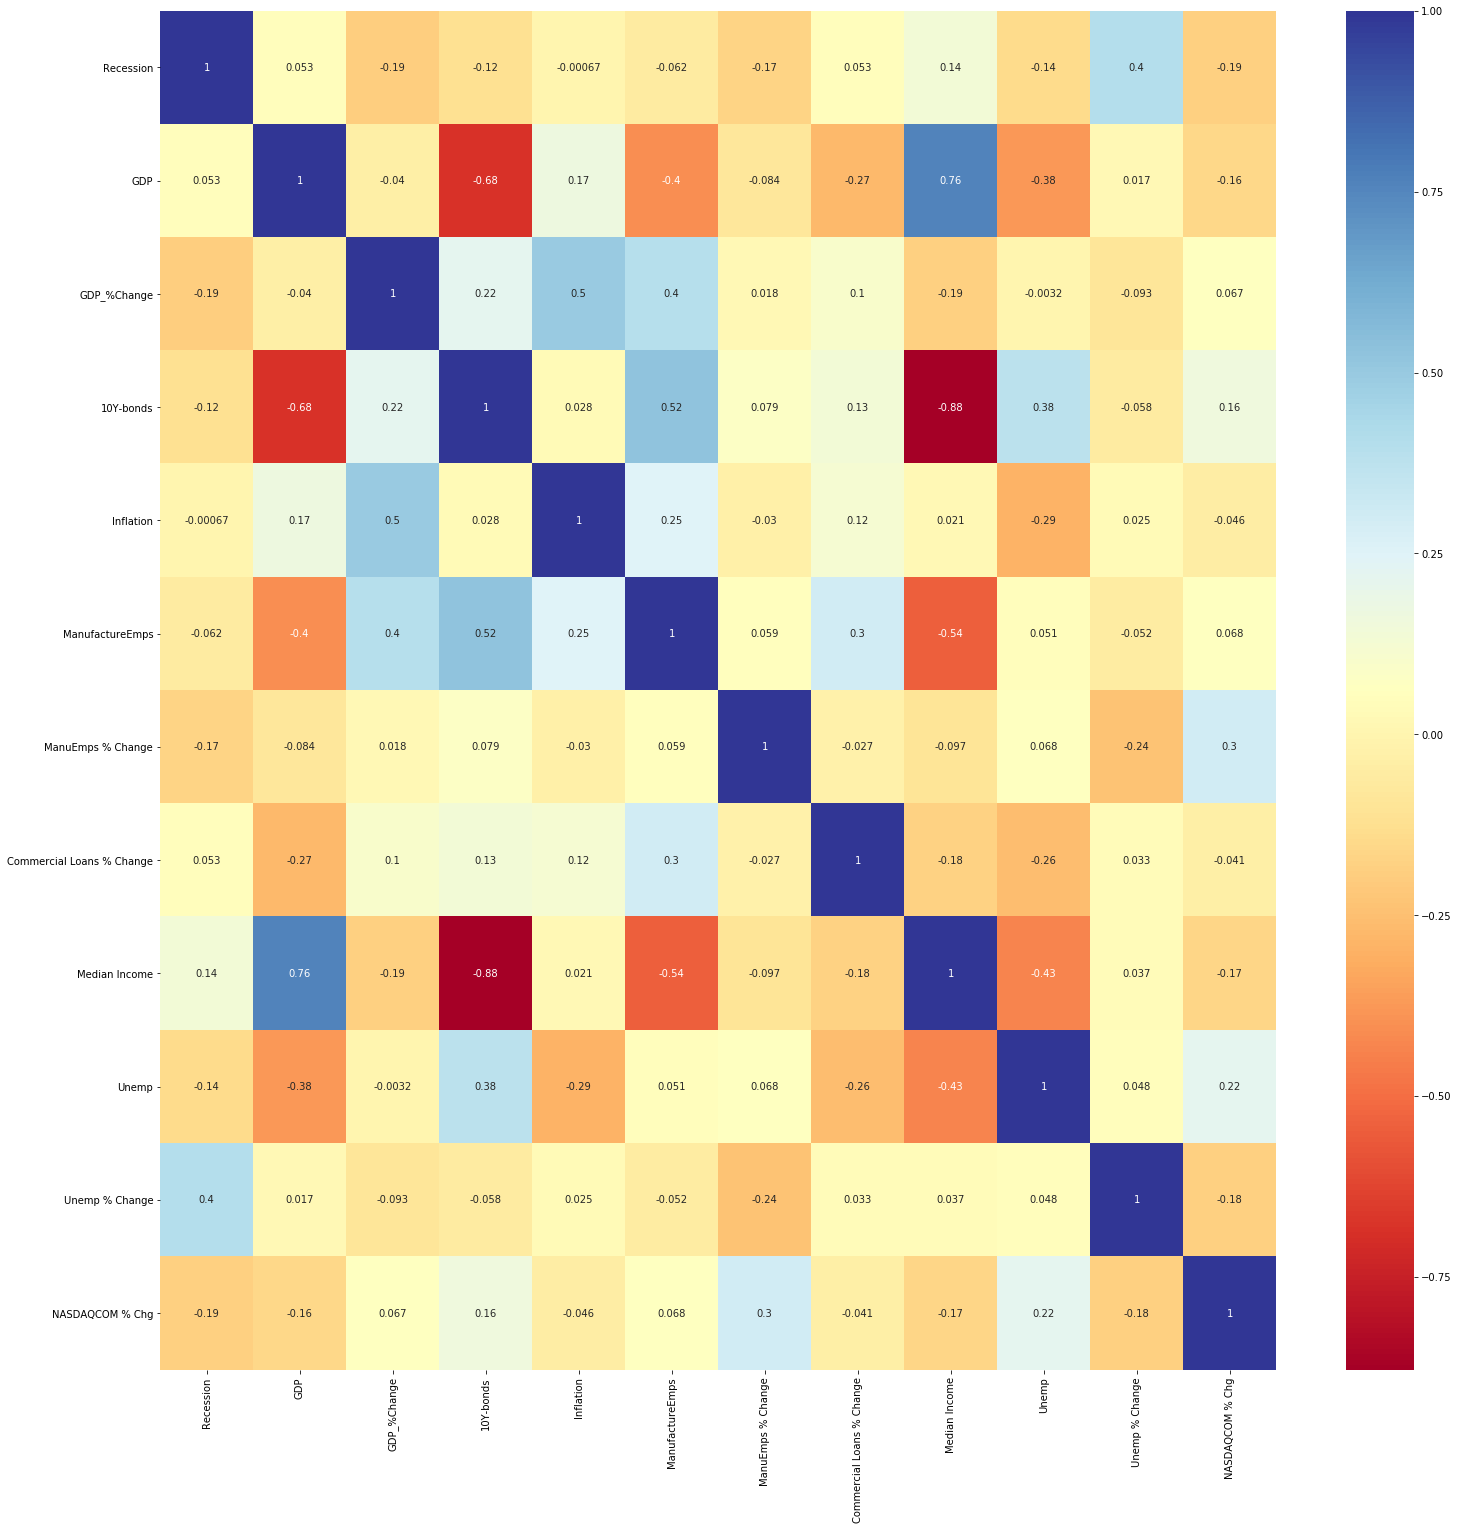

In [157]:
corr = df_merged.corr(method='kendall')
plt.figure(figsize=(25,25))
sns.heatmap(corr, annot=True, cmap="RdYlBu")

# China Data

In [160]:
china_recession = get_fred_series('CHNRECDM', '1970-01-01', 'Recession')
china_recession

,Recession
1978-01-01,1.0
1978-01-02,1.0
1978-01-03,1.0
1978-01-04,1.0
1978-01-05,1.0
...,...
2019-12-27,1.0
2019-12-28,1.0
2019-12-29,1.0
2019-12-30,1.0


In [161]:
china_gdp = get_fred_series('MKTGDPCNA646NWDB', '1970-01-01', 'GDP')
china_gdp

,GDP
1970-01-01,9.260297e+10
1971-01-01,9.980096e+10
1972-01-01,1.136876e+11
1973-01-01,1.385443e+11
1974-01-01,1.441821e+11
1975-01-01,1.634316e+11
1976-01-01,1.539405e+11
1977-01-01,1.749381e+11
1978-01-01,1.495408e+11
1979-01-01,1.782806e+11


In [162]:
china_gdp_pctcg = get_fred_series('MKTGDPCNA646NWDB', '1970-01-01', 'GDP_%Change', pct_change=True)
china_gdp_pctcg

,GDP_%Change
1970-01-01,0.161808
1971-01-01,0.077730
1972-01-01,0.139143
1973-01-01,0.218640
1974-01-01,0.040693
1975-01-01,0.133508
1976-01-01,-0.058074
1977-01-01,0.136401
1978-01-01,-0.145179
1979-01-01,0.192187


In [163]:
china_unemp = get_fred_series('LMUNRRTTCNA156N', '1970-01-01', 'Unemp')
china_unemp

,Unemp
1978-01-01,5.30
1979-01-01,5.40
1980-01-01,4.90
1981-01-01,3.80
1982-01-01,3.20
1983-01-01,2.30
1984-01-01,1.90
1985-01-01,1.80
1986-01-01,2.00
1987-01-01,2.00
